In [15]:
import matplotlib.pyplot as plt
import numpy as np
import libfmp.c3
import librosa

# Motivação da DTW:
Dado duas sequências $X:=(x_1,x_2,\ldots,x_N)$ de comprimento $N\in\mathbb{N}$ e $Y:=(y_1,y_2,\ldots,y_M)$ de comprimento $M\in\mathbb{N}$, o objetivo da dynamic time warping (DTW) é alinhar temporalmente essas duas sequências de forma otimizada sob certas restrições. As sequências podem ser sinais discretos, sequências de características, sequências de caracteres ou qualquer tipo de série temporal. Geralmente, os índices das sequências correspondem a pontos sucessivos no tempo, espaçados em intervalos de tempo uniformes.

# Warping Path:
Para modelar um alinhamento global entre os elementos das sequências $X$ e $Y$, a ideia é considerar uma sequência de pares de índices que atendem a certas restrições. Isso leva à noção de um **Warping Path**. Por definição, um caminho de deformação (**Warping Path**) $(N,M)$ de comprimento $L\in\mathbb{N}$ é uma sequência

$$P=(p_1,\ldots,p_L)$$

com $p_\ell=(n_\ell,m_\ell)\in[1:N]\times [1:M]$ para $\ell\in[1:L]$, satisfazendo as seguintes condições:

* Condição de limite: $p_1= (1,1)$ e $p_L=(N,M)$
* Condição de monotonicidade: $n_1\leq n_2\leq\ldots \leq n_L$ e $m_1\leq m_2\leq \ldots \leq m_L$
* Condição de tamanho de passo: $p_{\ell+1}-p_\ell\in \Sigma:=\{(1,0),(0,1),(1,1)\}$ para $\ell\in[1:L]$

Um **Warping Path** $(N,M)$ define um alinhamento entre duas sequências $X=(x_1,x_2,\ldots,x_N)$ e $Y=(y_1,y_2,\ldots,y_M)$ atribuindo o elemento $x_{n_\ell}$ de $X$ ao elemento $y_{m_\ell}$ de $Y$. A condição de limite garante que os primeiros elementos de $X$ e $Y$, assim como os últimos elementos de $X$ e $Y$, estejam alinhados entre si. A condição de monotonicidade reflete a exigência de uma temporização fiel: se um elemento em $X$ precede um segundo elemento em $X$, isso também deve valer para os elementos correspondentes em $Y$, e vice-versa. Por fim, a condição de tamanho de passo em relação ao conjunto $\Sigma$ expressa uma espécie de condição de continuidade: nenhum elemento em $X$ e $Y$ pode ser omitido, e não há replicação no alinhamento.

## Matriz de Custo:
A seguir, introduzimos uma noção que nos diz algo sobre a **qualidade** de um **Warping Path**. Para isso, precisamos de uma maneira de comparar numericamente os elementos das sequências de características $X$ e $Y$. Seja $\mathcal{F}$ um **espaço de características** e assuma que $x_n, y_m \in \mathcal{F}$ para $n \in [1:N]$ e $m \in [1:M]$. Para comparar dois recursos diferentes $x$ e $y \in \mathcal{F}$, é necessário uma **medida de custo local**, que é definida como uma função
$$c:\mathcal{F}\times\mathcal{F}\to \mathbb{R}.$$
Tipicamente, $c(x,y)$ é pequeno (baixo custo) se $x$ e $y$ forem semelhantes entre si e, caso contrário, $c(x,y)$ é grande (alto custo). Avaliando a medida de custo local para cada par de elementos das sequências $X$ e $Y$, obtém-se uma **matriz de custo** $C\in\mathbb{R}^{N\times M}$ definida por:
$$C(n,m):=c(x_n,y_m)$$
para $n \in [1:N]$ e $m \in [1:M]$. Uma tupla $(n,m)$ representando uma entrada da matriz $C$ será referida como uma **célula** da matriz. O **custo total** $c_P(X,Y)$ de um caminho de deformação (**WP**) $P$ entre duas sequências $X$ e $Y$ com relação à medida de custo local $c$ é definido como
$$c_P:=\sum_{\ell=1}^L c(x_{n_\ell},y_{m_\ell}) = \sum_{\ell=1}^L C(n_\ell,m_\ell).$$
A intuição dessa definição é que o caminho de deformação (**WP**) acumula o custo de todas as células por onde passa. Um caminho de deformação é "bom" se seu custo total for baixo e é "ruim" se seu custo total for alto.  


## Optimal Warping Path

Agora, estamos interessados em um **Optimal Warping Path** entre $X$ e $Y$, que é definido como um caminho de deformação $P^\ast$ que possui o custo total mínimo entre todos os caminhos de deformação possíveis. As células deste caminho de deformação codificam um alinhamento global ótimo entre os elementos das duas sequências, onde as condições do caminho de deformação garantem que cada elemento da sequência $X$ seja atribuído a pelo menos um elemento de $Y$ e vice-versa. Isso nos leva à definição do **caminho DTW** denotada como $\mathrm{DTW}(X,Y)$ entre as duas sequências $X$ de comprimento $N$ e $Y$ de comprimento $M$, que é definida como o custo total de um caminho de **optimal warping path** $(N,M)$:

\begin{align}
     \mathrm{DTW}(X,Y) &:= c_{P^\ast}(X,Y) \\
                       &= \min\{c_P(X,Y) \mid P \text{ é um optimal warping path $(N,M)$} \}
\end{align}

## Algoritmo DTW usando Programação Dinâmica

Para determinar um caminho de alinhamento ótimo(**Optimal Warping Path**) $P∗$  para duas sequências  $X$  e  $Y$ , poderíamos calcular o custo total de todos os possíveis caminhos de alinhamento  $(N, M)$  e então escolher o custo mínimo. No entanto, o número de diferentes caminhos de alinhamento  $(N, M)$  é exponencial em  $N$  e  $M$ . Portanto, uma abordagem ingênua como essa é computacionalmente inviável para grandes valores de  $N$  e  $M$ . Introduzimos agora um algoritmo  $O(NM)$  baseado em programação dinâmica.

A ideia geral por trás da programação dinâmica é decompor um problema dado em subproblemas mais simples e, em seguida, combinar as soluções dos subproblemas para chegar a uma solução geral. No caso da DTW, a ideia é derivar um caminho de alinhamento ótimo para as sequências originais a partir de caminhos de alinhamento ótimos para subsequências truncadas. Essa ideia pode então ser aplicada recursivamente. Para formalizar essa ideia, definimos as sequências de prefixo  $X(1:n) := (x₁, ..., xₙ)$  para  $n ∈ [1:N]$  e  $Y(1:m) := (y₁, ..., yₘ)$  para  $m ∈ [1:M]$  e definimos
$$D(n, m) := DTW(X(1:n), Y(1:m))$$
Os valores  $D$  definem uma matriz  $(N×M)$  denominada matriz de custo acumulado. Cada valor  $D(n, m)$  especifica o custo total (ou acumulado) de um caminho de alinhamento ótimo que começa na célula  $(1, 1)$  e termina na célula  $(n, m)$ . Obviamente, temos  $D(N, M) = DTW(X, Y)$ .A seguir temos a descrição do Algoritmo DTW baseado em programação dinâmica. Na primeira parte, a matriz de custo acumulado  $D$  é calculada de forma iterativa usando um loop aninhado. Na segunda parte, o caminho de alinhamento ótimo é calculado usando um procedimento de retrocesso.


## Algoritmo: DTW
**Entrada:** Matriz de custo $C$ de tamanho $N × M$  
**Saída:** Matriz de custo acumulado $D$ Caminho de alinhamento ótimo **(OWP)** $P∗$  
**Procedimento:**
1. Inicialize a matriz $D_{(N × M)}$, definindo $D(n,1) = ∑ₖ₌₁ⁿ C(k,1)$ para $n ∈ [1 : N]$ e $D(1,m) = ∑ₖ₌₁ᵐ C(1, k)$ para $m ∈ [1 : M]$.
2. Em seguida, calcule em um loop aninhado para $n = 2,...,N$ e $m = 2,...,M$:
   $$D(n,m) = C(n,m) + \min\{D(n-1,m-1),D(n-1,m),D(n,m-1)\}.$$
3. Defina  $l = 1$ e $q_l = (N, M)$. Repita as seguintes etapas até $q_l = (1, 1)$:
    - Incremente $l$ por um e deixe $(n,m) = q_{l-1}$.
    - Se $n = 1$, então $q_l = (1, m-1)$,
    - Senão, se $m = 1$, então $q_l = (n-1, m)$,
    - Senão, $q_l = argmin\{D(n-1,m-1),D(n-1,m),D(n,m-1)\}$.
      (Se '$argmin$' não for único, escolha a célula lexicograficamente menor.)
4. Defina $L = l$ e retorne $P∗ = (qL, qL₋₁, ..., q₁)$ bem como $D$.

## Algoritimo para calcular a matriz de custo (C):

In [2]:
def matriz_custo(sinal_1, sinal_2, metrica='euclideana'):
    """ Calcula a matriz de custo entre dois sinais utilizando distancia euclideana.
    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal.
    - sinal_2 (array-like): Segundo sinal.
    Retorna:
    - C (ndarray): Matriz de custo entre os sinais. """
    # Transformando o sinal em um array, caso seja dado uma lista    
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    #criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])
    return C

## Exemplo:

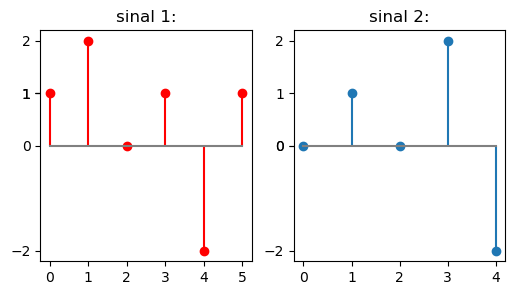

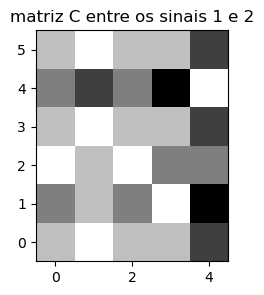

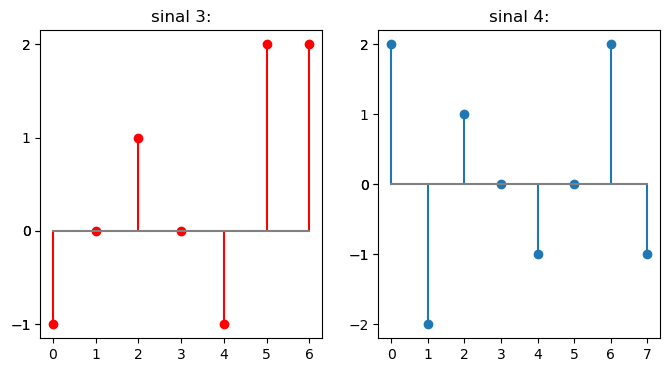

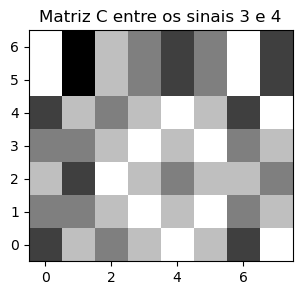

In [3]:
# Sinais 1 e 2
#sinal_1 = np.array([1, 2, 0, 1, -2, 1])
#sinal_2 = np.array([0, 1, 0, 2, -2])
sinal_1 = np.array([1, 2, 0, 1, -2, 1])
sinal_2 = np.array([0, 1, 0, 2, -2])
t_1 = np.arange(0,sinal_1.shape[0], 1) 
t_2 = np.arange(0,sinal_2.shape[0], 1)
matriz_custo_1 = matriz_custo(sinal_1, sinal_2)

fig, (x1, x2) = plt.subplots(1, 2, figsize=(6, 3)) 
x1.stem(t_1, sinal_1, basefmt='gray', linefmt='r-')
x2.stem(t_2, sinal_2, basefmt='gray')
x1.set_title("sinal 1:")
x2.set_title("sinal 2:")
x1.set_xticks(t_1)
x1.set_yticks(sinal_1)
x2.set_xticks(t_2)
x2.set_yticks(sinal_2)
plt.show()

plt.figure(figsize=(4, 3))
plt.title("matriz C entre os sinais 1 e 2")
plt.imshow(matriz_custo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")

# Sinais 3 e 4
sinal_3 = np.array([-1, 0, 1, 0, -1, 2, 2])
sinal_4 = np.array([2, -2, 1, 0, -1, 0, 2, -1])
t_3 = np.arange(0,sinal_3.shape[0], 1) 
t_4 = np.arange(0,sinal_4.shape[0], 1)
matriz_custo_2 = matriz_custo(sinal_3, sinal_4)

fig, (x1, x2) = plt.subplots(1, 2, figsize=(8, 4)) 
x1.stem(t_3, sinal_3, basefmt='gray', linefmt='r-')
x2.stem(t_4, sinal_4, basefmt='gray')
x1.set_title("sinal 3:")
x2.set_title("sinal 4:")
x1.set_xticks(t_3)
x1.set_yticks(sinal_3)
x2.set_xticks(t_4)
x2.set_yticks(sinal_4)
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Matriz C entre os sinais 3 e 4")
plt.imshow(matriz_custo_2, cmap=plt.cm.binary, interpolation="nearest", origin="lower");

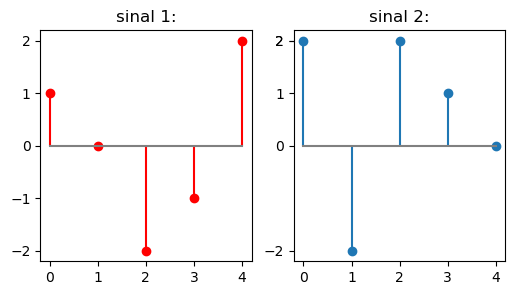

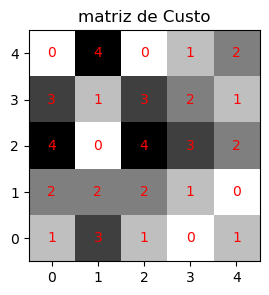

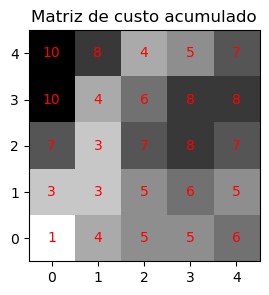

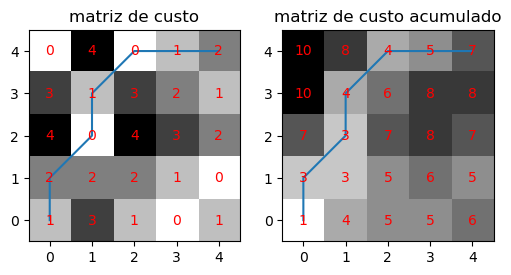

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def matriz_custo(sinal_1, sinal_2, metrica='euclideana'):
    """ Calcula a matriz de custo entre dois sinais utilizando distancia euclideana.
    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal.
    - sinal_2 (array-like): Segundo sinal.
    Retorna:
    - C (ndarray): Matriz de custo entre os sinais. """
    # Transformando o sinal em um array, caso seja dado uma lista    
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])
    return C

def matriz_custo_cumulativo(C):
    """ Calcula a matriz de custo cumulativo para uma matriz de custo original.
    Parâmetros:
    - C (numpy.ndarray): Matriz de custo original.
    Retorna:
    - numpy.ndarray: Matriz de custo cumulativo, onde D[i, j] representa o custo cumulativo mínimo
                    até a posição (i, j) na matriz original C.
    A função utiliza programação dinâmica para calcular iterativamente os custos cumulativos mínimos
    considerando três movimentos possíveis: diagonal (amostras iguais), esquerda (adicionar uma amostra)
    e cima (remover uma amostra). O resultado é uma matriz de custo cumulativo mínima. """
    # Obtém as dimensões da matriz de custo original
    N = C.shape[0]
    M = C.shape[1]
    
    # Inicializa a matriz de custo cumulativo com zeros
    D = np.zeros((N + 1, M + 1))
    
    # Define infinito nas bordas superiores e laterais da matriz
    for i in range(1, N + 1):
        D[i, 0] = np.inf
    for i in range(1, M + 1):
        D[0, i] = np.inf
    
    # Preenche iterativamente a matriz de custo cumulativo
    for i in range(N):
        for j in range(M):
            # Lista os custos acumulados das posições vizinhas
            custo_anterior = [
                D[i, j],         # custo vindo da diagonal (amostras iguais)
                D[i, j + 1],      # custo vindo da esquerda (adicionar uma amostra)
                D[i + 1, j]       # custo vindo de cima (remover uma amostra)
            ]
            # Identifica a posição do custo mínimo
            i_custo_anterior = np.argmin(custo_anterior)
            
            # Calcula o custo cumulativo mínimo para a posição atual
            D[i + 1, j + 1] = C[i, j] + custo_anterior[i_custo_anterior]
    
    # Remove a linha e coluna adicionadas para inicialização
    D = D[1:, 1:]
    return D

def Optimal_Warping_Path(D):
    """ Calcula o caminho de deformação ótimo com base em uma matriz de custo D.
    Parâmetros:
    - D (numpy.ndarray): Matriz de custo acumulado entre dois sinais.
    Retorna:
    - numpy.ndarray: Matriz de índices representando o caminho de deformação ótimo.
    A função utiliza a matriz de custo D para encontrar o caminho de warping ótimo,
    começando do ponto (N-1, M-1) até o ponto (0, 0), onde N e M são as dimensões
    da matriz de custo D. O caminho ótimo é retornado como uma matriz de índices. """

    N = D.shape[0]
    M = D.shape[1]

    i = N - 1       # Inicializa a posição vertical no ponto mais inferior
    j = M - 1       # Inicializa a posição horizontal no ponto mais à direita
    P = [(i, j)]    # Lista que armazenará os pontos do caminho ótimo

    # Enquanto não atingirmos a origem (0, 0)
    while i > 0 or j > 0:
        if i == 0:
            cell = (0, j - 1)  # Se atingir a borda superior, apenas mova para a esquerda
        elif j == 0:
            cell = (i - 1, 0)  # Se atingir a borda esquerda, apenas mova para cima
        else:
            # Encontrar a posição vizinha com o menor custo
            val = min(D[i - 1, j - 1], D[i - 1, j], D[i, j - 1])
            if val == D[i - 1, j - 1]:
                cell = (i - 1, j - 1)  # Movimento diagonal (amostras iguais)
            elif val == D[i - 1, j]:
                cell = (i - 1, j)      # Movimento para cima (remover uma amostra)
            else:
                cell = (i, j - 1)      # Movimento para a esquerda (adicionar uma amostra)
        
        P.append(cell)  # Adiciona a posição ao caminho ótimo
        (i, j) = cell   # Atualiza a posição para a próxima iteração

    P.reverse()       # Inverte a ordem do caminho para começar do ponto inicial
    P = np.array(P)   # Converte a lista de pontos em uma matriz numpy
    return P          # Retorna o caminho ótimo como uma matriz de índices


# Sinais 1 e 2

# Função para gerar um sinal aleatório
def gerar_sinal_aleatorio():
    tamanho = 5  # Gera um tamanho aleatório entre 4 e 6
    sinal = np.random.randint(-2, 3, tamanho)  # Gera valores aleatórios entre -2 e 2
    return sinal

# Gerar os dois sinais aleatórios
#sinal_1 = gerar_sinal_aleatorio()
#sinal_2 = gerar_sinal_aleatorio()

#print(sinal_1,sinal_2)

sinal_1 = np.array([1, 0, -2, -1, 2])
sinal_2 = np.array([2, -2, 2, 1, 0])
t_1 = np.arange(0, sinal_1.shape[0], 1)
t_2 = np.arange(0, sinal_2.shape[0], 1)
matriz_custo_1 = matriz_custo(sinal_1, sinal_2)

fig, (x1, x2) = plt.subplots(1, 2, figsize=(6, 3))
x1.stem(t_1, sinal_1, basefmt='gray', linefmt='r-')
x2.stem(t_2, sinal_2, basefmt='gray')
x1.set_title("sinal 1:")
x2.set_title("sinal 2:")
x1.set_xticks(t_1)
x1.set_yticks(sinal_1)
x2.set_xticks(t_2)
x2.set_yticks(sinal_2)
plt.show()

plt.figure(figsize=(4, 3))
plt.title("matriz de Custo")
plt.imshow(matriz_custo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
# Adicionando valores dentro da matriz
for i in range(matriz_custo_1.shape[0]):
    for j in range(matriz_custo_1.shape[1]):
        plt.text(j, i, f'{matriz_custo_1[i, j]:.0f}', ha='center', va='center', color='red')
plt.show()

matriz_custo_cumulativo_1 = matriz_custo_cumulativo(matriz_custo_1)

plt.figure(figsize=(4, 3))
plt.title("Matriz de custo acumulado")
plt.imshow(matriz_custo_cumulativo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
# Adicionando valores dentro da matriz de custo acumulado
for i in range(matriz_custo_cumulativo_1.shape[0]):
    for j in range(matriz_custo_cumulativo_1.shape[1]):
        plt.text(j, i, f'{matriz_custo_cumulativo_1[i, j]:.0f}', ha='center', va='center', color='red')
plt.show()

OWP_1 = Optimal_Warping_Path(matriz_custo_cumulativo_1)

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("matriz de custo")
plt.imshow(matriz_custo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*OWP_1)
plt.plot(y_caminho_1, x_caminho_1)
for i in range(matriz_custo_1.shape[0]):
    for j in range(matriz_custo_1.shape[1]):
        plt.text(j, i, f'{matriz_custo_1[i, j]:.0f}', ha='center', va='center', color='red')

plt.subplot(122)
plt.title("matriz de custo acumulado")
plt.imshow(matriz_custo_cumulativo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*OWP_1)
plt.plot(y_caminho_1, x_caminho_1)
for i in range(matriz_custo_cumulativo_1.shape[0]):
    for j in range(matriz_custo_cumulativo_1.shape[1]):
        plt.text(j, i, f'{matriz_custo_cumulativo_1[i, j]:.0f}', ha='center', va='center', color='red')

plt.show()

In [5]:
import numpy as np

def DTW_restrito(sinal_1, sinal_2, tipo='horizontal'):
    """
    Calcula o alinhamento dinâmico temporal (Dynamic Time Warping - DTW) entre dois sinais temporais
    com condição de passo restrito.

    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal temporal.
    - sinal_2 (array-like): Segundo sinal temporal.
    - tipo (str): Tipo de condição de passo ('horizontal' para movimentos diagonais e horizontais,
                  'vertical' para movimentos diagonais e verticais).

    Retorna:
    - C (array): Matriz de custo entre as amostras dos dois sinais.
    - D (array): Matriz de custo cumulativo para o alinhamento dinâmico.
    - P (array): Caminho de deformação ótimo como uma matriz de pontos.
    """
    
    # Transformando o sinal em um array, caso seja dado uma lista
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])

    # Calcula a matriz de custo cumulativo
    # Obtém as dimensões da matriz de custo original
    N = C.shape[0]
    M = C.shape[1]

    # Inicializa a matriz de custo cumulativo com infinito
    D = np.full((N + 1, M + 1), np.inf)
    D[0, 0] = 0

    # Preenche iterativamente a matriz de custo cumulativo
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            if tipo == 'horizontal':
                D[i, j] = C[i - 1, j - 1] + min(D[i - 1, j - 1], D[i - 1, j])
            elif tipo == 'vertical':
                D[i, j] = C[i - 1, j - 1] + min(D[i - 1, j - 1], D[i, j - 1])

    # Remove a linha e coluna adicionadas para inicialização
    D = D[1:, 1:]

    # Calcula o caminho de deformação ótimo
    i, j = N - 1, M - 1
    P = [(i, j)]

    while i > 0 or j > 0:
        if tipo == 'horizontal':
            if i == 0:
                j -= 1
            elif j == 0:
                i -= 1
            else:
                if D[i, j] == C[i, j] + D[i - 1, j - 1]:
                    i -= 1
                    j -= 1
                elif D[i, j] == C[i, j] + D[i - 1, j]:
                    i -= 1
        elif tipo == 'vertical':
            if i == 0:
                j -= 1
            elif j == 0:
                i -= 1
            else:
                if D[i, j] == C[i, j] + D[i - 1, j - 1]:
                    i -= 1
                    j -= 1
                elif D[i, j] == C[i, j] + D[i, j - 1]:
                    j -= 1

        P.append((i, j))

    P.reverse()
    P = np.array(P)

    return C, D, P


## Algoritimo para matriz de custo acumulado (D):

<Figure size 1200x800 with 0 Axes>

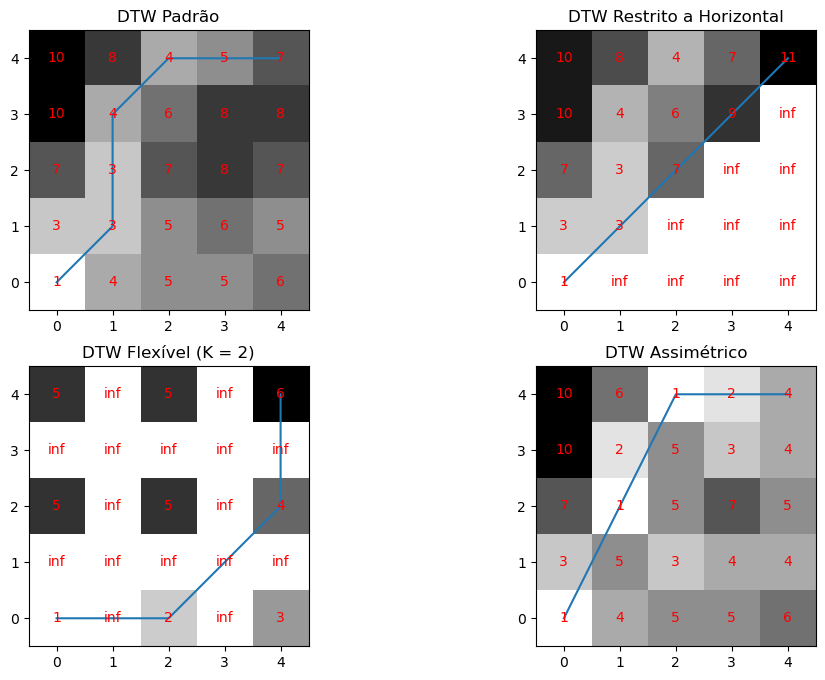

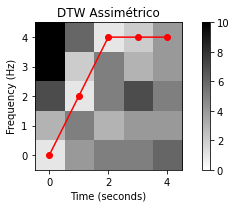

In [37]:
import numpy as np

def DTW(sinal_1, sinal_2):
    """
    Calcula o alinhamento dinâmico temporal (Dynamic Time Warping - DTW) entre dois sinais temporais.
    
    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal temporal.
    - sinal_2 (array-like): Segundo sinal temporal.
    
    Retorna:
    - C (array): Matriz de custo entre as amostras dos dois sinais.
    - D (array): Matriz de custo cumulativo para o alinhamento dinâmico.
    - P (array): Caminho de deformação ótimo como uma matriz de pontos.
    """
    # Transformando o sinal em um array, caso seja dado uma lista
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])

    # Define o conjunto de movimentos permitidos
    Sigma = {(1, 0), (0, 1), (1, 1)}

    # Inicializa a matriz de custo cumulativo com infinito
    D = np.full((N + 1, M + 1), np.inf)
    D[0, 0] = 0

    # Inicializa a fronteira da matriz D
    for i in range(1, N + 1):
        D[i, 0] = np.inf if (1, 0) not in Sigma else 0
    for j in range(1, M + 1):
        D[0, j] = np.inf if (0, 1) not in Sigma else 0

    # Preenche iterativamente a matriz de custo cumulativo
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            if (1, 1) in Sigma:
                min_cost = min(D[i-1, j-1], D[i-1, j] if (1, 0) in Sigma else np.inf, D[i, j-1] if (0, 1) in Sigma else np.inf)
            elif (1, 0) in Sigma:
                min_cost = D[i-1, j]
            elif (0, 1) in Sigma:
                min_cost = D[i, j-1]
            D[i, j] = C[i-1, j-1] + min_cost

    # Remove a linha e coluna adicionadas para inicialização
    D = D[1:, 1:]

    # Calcula o caminho de deformação ótimo
    i, j = N - 1, M - 1
    P = [(i, j)]

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            movimentos = [(i-1, j-1), (i-1, j), (i, j-1)]
            custos = [D[m[0], m[1]] if (i - m[0], j - m[1]) in Sigma else np.inf for m in movimentos]
            min_index = np.argmin(custos)
            i, j = movimentos[min_index]

        P.append((i, j))

    P.reverse()
    P = np.array(P)

    return C, D, P

def DTW_restrito(sinal_1, sinal_2, tipo='horizontal'):
    """
    Calcula o alinhamento dinâmico temporal (Dynamic Time Warping - DTW) entre dois sinais temporais
    com condição de passo restrito.

    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal temporal.
    - sinal_2 (array-like): Segundo sinal temporal.
    - tipo (str): Tipo de condição de passo ('horizontal' para movimentos diagonais e horizontais,
                  'vertical' para movimentos diagonais e verticais).

    Retorna:
    - C (array): Matriz de custo entre as amostras dos dois sinais.
    - D (array): Matriz de custo cumulativo para o alinhamento dinâmico.
    - P (array): Caminho de deformação ótimo como uma matriz de pontos.
    """
    # Transformando o sinal em um array, caso seja dado uma lista
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])

    # Define o conjunto de movimentos permitidos
    Sigma_horizontal = {(1, 0), (1, 1)}
    Sigma_vertical = {(0, 1), (1, 1)}

    # Inicializa a matriz de custo cumulativo com infinito
    D = np.full((N + 1, M + 1), np.inf)
    D[0, 0] = 0

    # Inicializa a fronteira da matriz D
    if tipo == 'horizontal':
        for i in range(1, N + 1):
            D[i, 0] = np.inf
        for j in range(1, M + 1):
            D[0, j] = np.inf if (0, 1) not in Sigma_horizontal else 0
    elif tipo == 'vertical':
        for i in range(1, N + 1):
            D[i, 0] = np.inf if (1, 0) not in Sigma_vertical else 0
        for j in range(1, M + 1):
            D[0, j] = np.inf

    # Preenche iterativamente a matriz de custo cumulativo
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            if tipo == 'horizontal':
                D[i, j] = C[i - 1, j - 1] + min(D[i - 1, j - 1], D[i, j - 1] if (0, 1) in Sigma_horizontal else np.inf)
            elif tipo == 'vertical':
                D[i, j] = C[i - 1, j - 1] + min(D[i - 1, j - 1], D[i - 1, j] if (1, 0) in Sigma_vertical else np.inf)

    # Remove a linha e coluna adicionadas para inicialização
    D = D[1:, 1:]

    # Calcula o caminho de deformação ótimo
    i, j = N - 1, M - 1
    P = [(i, j)]

    while i > 0 or j > 0:
        if tipo == 'horizontal':
            if i == 0:
                j -= 1
            elif j == 0:
                i -= 1
            else:
                if D[i, j] == C[i, j] + D[i - 1, j - 1]:
                    i -= 1
                    j -= 1
                elif D[i, j] == C[i, j] + D[i, j - 1]:
                    j -= 1
        elif tipo == 'vertical':
            if i == 0:
                j -= 1
            elif j == 0:
                i -= 1
            else:
                if D[i, j] == C[i, j] + D[i - 1, j - 1]:
                    i -= 1
                    j -= 1
                elif D[i, j] == C[i, j] + D[i - 1, j]:
                    i -= 1

        P.append((i, j))

    P.reverse()
    P = np.array(P)

    return C, D, P

def DTW_flexivel(sinal_1, sinal_2, K=1):
    """
    Calcula o alinhamento dinâmico temporal (Dynamic Time Warping - DTW) entre dois sinais temporais
    com condição de passo flexível.

    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal temporal.
    - sinal_2 (array-like): Segundo sinal temporal.
    - K (int): Tamanho máximo do passo permitido.

    Retorna:
    - C (array): Matriz de custo entre as amostras dos dois sinais.
    - D (array): Matriz de custo cumulativo para o alinhamento dinâmico.
    - P (array): Caminho de deformação ótimo como uma matriz de pontos.
    """

    # Transformando o sinal em um array, caso seja dado uma lista
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])

    # Define o conjunto de movimentos permitidos
    Sigma = {(1, 0), (0, 1), (1, 1)}

    # Calcula a matriz de custo cumulativo
    D = np.full((N + 1, M + 1), np.inf)
    D[0, 0] = 0

    # Preenche iterativamente a matriz de custo cumulativo
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            min_cost = np.inf
            for k in range(1, K + 1):
                if (1, 0) in Sigma and i - k >= 0:
                    min_cost = min(min_cost, D[i - k, j])
                if (0, 1) in Sigma and j - k >= 0:
                    min_cost = min(min_cost, D[i, j - k])
                if (1, 1) in Sigma and i - k >= 0 and j - k >= 0:
                    min_cost = min(min_cost, D[i - k, j - k])
            D[i, j] = C[i - 1, j - 1] + min_cost

    # Remove a linha e coluna adicionadas para inicialização
    D = D[1:, 1:]

    # Calcula o caminho de deformação ótimo
    i, j = N - 1, M - 1
    P = [(i, j)]

    while i > 0 or j > 0:
        melhor_passo = None
        melhor_custo = np.inf
        for k in range(1, K + 1):
            if (1, 1) in Sigma and i - k >= 0 and j - k >= 0 and D[i - k, j - k] < melhor_custo:
                melhor_passo = (i - k, j - k)
                melhor_custo = D[i - k, j - k]
            if (1, 0) in Sigma and i - k >= 0 and D[i - k, j] < melhor_custo:
                melhor_passo = (i - k, j)
                melhor_custo = D[i - k, j]
            if (0, 1) in Sigma and j - k >= 0 and D[i, j - k] < melhor_custo:
                melhor_passo = (i, j - k)
                melhor_custo = D[i, j - k]
        i, j = melhor_passo
        P.append((i, j))

    P.reverse()
    P = np.array(P)

    return C, D, P

def DTW_assimetrico(sinal_1, sinal_2):
    """
    Calcula o alinhamento dinâmico temporal (Dynamic Time Warping - DTW) entre dois sinais temporais
    com condição de passo assimétrico.

    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal temporal.
    - sinal_2 (array-like): Segundo sinal temporal.

    Retorna:
    - C (array): Matriz de custo entre as amostras dos dois sinais.
    - D (array): Matriz de custo cumulativo para o alinhamento dinâmico.
    - P (array): Caminho de deformação ótimo como uma matriz de pontos.
    """

    # Transformando o sinal em um array, caso seja dado uma lista
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])

    # Define o conjunto de movimentos permitidos
    Sigma = {(1, 0), (0, 1), (1, 1), (2, 1), (1, 2)}

    # Calcula a matriz de custo cumulativo
    D = np.full((N + 2, M + 2), np.inf)
    D[2, 2] = C[0, 0]

    # Preenche iterativamente a matriz de custo cumulativo
    for i in range(1, N):
        for j in range(1, M):
            custos = [
                D[i - 1 + 2, j - 1 + 2] if (1, 1) in Sigma else np.inf,  # Diagonal (1, 1)
                D[i - 2 + 2, j - 1 + 2] if (2, 1) in Sigma else np.inf,  # (2, 1)
                D[i - 1 + 2, j - 2 + 2] if (1, 2) in Sigma else np.inf,  # (1, 2)
                D[i - 0 + 2, j - 1 + 2] if (0, 1) in Sigma else np.inf,  # (0, 1)
                D[i - 1 + 2, j - 0 + 2] if (1, 0) in Sigma else np.inf   # (1, 0)
            ]
            min_custo = min(custos)
            D[i + 2, j + 2] = C[i, j] + min_custo

    D = D[2:, 2:]

    # Calcula o caminho de deformação ótimo
    i, j = N - 1, M - 1
    P = [(i, j)]

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            movimentos = [
                (i - 1, j - 1) if (1, 1) in Sigma else (np.inf, np.inf),  # Diagonal (1, 1)
                (i - 2, j - 1) if (2, 1) in Sigma else (np.inf, np.inf),  # (2, 1)
                (i - 1, j - 2) if (1, 2) in Sigma else (np.inf, np.inf),  # (1, 2)
                (i, j - 1) if (0, 1) in Sigma else (np.inf, np.inf),      # (0, 1)
                (i - 1, j) if (1, 0) in Sigma else (np.inf, np.inf)       # (1, 0)
            ]
            custos = [D[m[0], m[1]] if m != (np.inf, np.inf) else np.inf for m in movimentos]
            min_index = np.argmin(custos)
            i, j = movimentos[min_index]

        P.append((i, j))

    P.reverse()
    P = np.array(P)

    return C, D, P

#C, D, P = DTW(sinal_1,sinal_2)
#C_1, D_1, P_1 = DTW_restrito(sinal_1, sinal_2)
#C_2, D_2, P_2 = DTW_flexivel(sinal_1,sinal_2,K=2)
#C_3, D_3, P_3 = DTW_assimetrico(sinal_1,sinal_2)




# plt.figure(figsize=(12, 8))

# # Gráfico para DTW padrão
# plt.subplot(221)
# plt.title("DTW Padrão")
# plt.imshow(D, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
# x_caminho_1, y_caminho_1 = zip(*P)
# plt.plot(y_caminho_1, x_caminho_1)
# for i in range(D.shape[0]):
#     for j in range(D.shape[1]):
#         plt.text(j, i, f'{D[i, j]:.0f}', ha='center', va='center', color='red')

# # Gráfico para DTW restrito a horizontal
# plt.subplot(222)
# plt.title("DTW Restrito a Horizontal")
# plt.imshow(D_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
# x_caminho_1, y_caminho_1 = zip(*P_1)
# plt.plot(y_caminho_1, x_caminho_1)
# for i in range(D_1.shape[0]):
#     for j in range(D_1.shape[1]):
#         plt.text(j, i, f'{D_1[i, j]:.0f}', ha='center', va='center', color='red')

# # Gráfico para DTW flexível com K = 2
# plt.subplot(223)
# plt.title("DTW Flexível (K = 2)")
# plt.imshow(D_2, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
# x_caminho_1, y_caminho_1 = zip(*P_2)
# plt.plot(y_caminho_1, x_caminho_1)
# for i in range(D_2.shape[0]):
#     for j in range(D_2.shape[1]):
#         plt.text(j, i, f'{D_2[i, j]:.0f}', ha='center', va='center', color='red')

# # Gráfico para DTW assimétrico
# plt.subplot(224)
# plt.title("DTW Assimétrico")
# plt.imshow(D_3, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
# x_caminho_1, y_caminho_1 = zip(*P_3)
# plt.plot(y_caminho_1, x_caminho_1)
# for i in range(D_3.shape[0]):
#     for j in range(D_3.shape[1]):
#         plt.text(j, i, f'{D_3[i, j]:.0f}', ha='center', va='center', color='red')

#plt.tight_layout()
#plt.show()


#plt.show()



# Parâmetros
weights_mul = np.array([1, 1, 1])
band_rad = 0.25
global_constraints = False

sinal_1 = np.array([1, 0, -2, -1, 2])
sinal_2 = np.array([2, -2, 2, 1, 0])

plt.figure(figsize=(12, 8))

# # DTW Padrão
# step_sizes_sigma = np.array([[1, 0], [0, 1], [1, 1]])
# title = "DTW Padrão"
# D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
#                     global_constraints=global_constraints, band_rad=band_rad)
# D_max = np.nanmax(D[D != np.inf])
# libfmp.c3.plot_matrix_with_points(D, P, linestyle='-', aspect='equal', clim=[0, D_max], title=title)
# x_caminho_1, y_caminho_1 = zip(*P)
# for x, y in zip(*np.where(np.isinf(D))):
#     plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')



plt.figure(figsize=(12, 8))
plt.subplot(221)
step_sizes_sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
                    global_constraints=global_constraints, band_rad=band_rad)
D_max = np.nanmax(D[D != np.inf])
plt.title("DTW Padrão")
plt.imshow(D, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*P)
plt.plot(y_caminho_1, x_caminho_1)
for i in range(D.shape[0]):
     for j in range(D.shape[1]):
         plt.text(j, i, f'{D[i, j]:.0f}', ha='center', va='center', color='red')



plt.subplot(222)
step_sizes_sigma = np.array([[1, 0], [1, 1]])
D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
                    global_constraints=global_constraints, band_rad=band_rad)
D_max = np.nanmax(D[D != np.inf])
plt.title("DTW Restrito a Horizontal")
plt.imshow(D, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*P)
plt.plot(y_caminho_1, x_caminho_1)
for i in range(D.shape[0]):
     for j in range(D.shape[1]):
         plt.text(j, i, f'{D[i, j]:.0f}', ha='center', va='center', color='red')


plt.subplot(223)
step_sizes_sigma = np.array([[2, 0], [0, 2], [2, 2]])
D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
                    global_constraints=global_constraints, band_rad=band_rad)
D_max = np.nanmax(D[D != np.inf])
plt.title("DTW Flexível (K = 2)")
plt.imshow(D, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*P)
plt.plot(y_caminho_1, x_caminho_1)
for i in range(D.shape[0]):
     for j in range(D.shape[1]):
         plt.text(j, i, f'{D[i, j]:.0f}', ha='center', va='center', color='red')

plt.subplot(224)
step_sizes_sigma = np.array([[1, 0], [0, 1], [2, 1], [1, 2]])
D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
                    global_constraints=global_constraints, band_rad=band_rad)
D_max = np.nanmax(D[D != np.inf])
plt.title("DTW Assimétrico")
plt.imshow(D, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*P)
plt.plot(y_caminho_1, x_caminho_1)
for i in range(D.shape[0]):
     for j in range(D.shape[1]):
         plt.text(j, i, f'{D[i, j]:.0f}', ha='center', va='center', color='red')






# # DTW Restrito a Horizontal
# step_sizes_sigma = np.array([[1, 0], [1, 1]])
# title = "DTW Restrito a Horizontal"
# D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
#                     global_constraints=global_constraints, band_rad=band_rad)
# D_max = np.nanmax(D[D != np.inf])
# libfmp.c3.plot_matrix_with_points(D, P, linestyle='-', aspect='equal', clim=[0, D_max], title=title)
# x_caminho_1, y_caminho_1 = zip(*P)
# for x, y in zip(*np.where(np.isinf(D))):
#     plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')

# # DTW Flexível (K = 2)
# step_sizes_sigma = np.array([[2, 0], [0, 2], [2, 2]])
# title = "DTW Flexível (K = 2)"
# D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
#                     global_constraints=global_constraints, band_rad=band_rad)
# D_max = np.nanmax(D[D != np.inf])
# libfmp.c3.plot_matrix_with_points(D, P, linestyle='-', aspect='equal', clim=[0, D_max], title=title)
# x_caminho_1, y_caminho_1 = zip(*P)
# for x, y in zip(*np.where(np.isinf(D))):
#     plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')

#DTW Assimétrico
step_sizes_sigma = np.array([[1, 0], [0, 1], [2, 1], [1, 2]])
title = "DTW Assimétrico"
D, P = librosa.sequence.dtw(X=sinal_1, Y=sinal_2, metric='euclidean', weights_mul=np.ones(step_sizes_sigma.shape[0]), step_sizes_sigma=step_sizes_sigma, 
                    global_constraints=global_constraints, band_rad=band_rad)
D_max = np.nanmax(D[D != np.inf])
libfmp.c3.plot_matrix_with_points(D, P, linestyle='-', aspect='equal', clim=[0, D_max], title=title)
x_caminho_1, y_caminho_1 = zip(*P)
for x, y in zip(*np.where(np.isinf(D))):
    plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

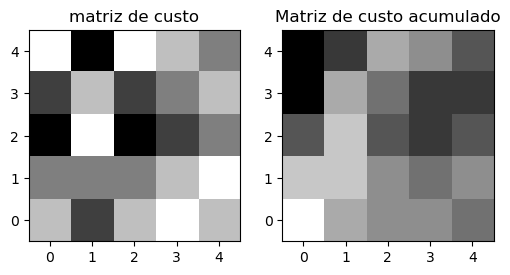

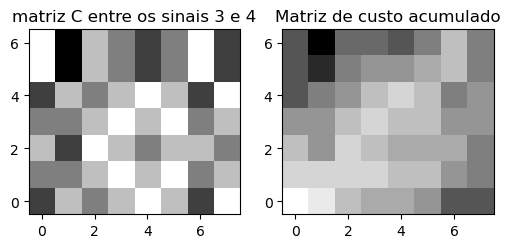

In [7]:
matriz_custo_cumulativo_1 = matriz_custo_cumulativo(matriz_custo_1)
plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("matriz de custo")
plt.imshow(matriz_custo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Matriz de custo acumulado")
plt.imshow(matriz_custo_cumulativo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")


matriz_custo_cumulativo_2 = matriz_custo_cumulativo(matriz_custo_2)
plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("matriz C entre os sinais 3 e 4")
plt.imshow(matriz_custo_2, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Matriz de custo acumulado")
plt.imshow(matriz_custo_cumulativo_2, cmap=plt.cm.binary, interpolation="nearest", origin="lower");

## Algoritmo para calcular o Optimal Warping Path:

In [8]:
def Optimal_Warping_Path(D):
    """ Calcula o caminho de deformação ótimo com base em uma matriz de custo D.
    Parâmetros:
    - D (numpy.ndarray): Matriz de custo acumulado entre dois sinais.
    Retorna:
    - numpy.ndarray: Matriz de índices representando o caminho de deformação ótimo.
    A função utiliza a matriz de custo D para encontrar o caminho de warping ótimo,
    começando do ponto (N-1, M-1) até o ponto (0, 0), onde N e M são as dimensões
    da matriz de custo D. O caminho ótimo é retornado como uma matriz de índices. """

    N = D.shape[0]
    M = D.shape[1]

    i = N - 1       # Inicializa a posição vertical no ponto mais inferior
    j = M - 1       # Inicializa a posição horizontal no ponto mais à direita
    P = [(i, j)]    # Lista que armazenará os pontos do caminho ótimo

    # Enquanto não atingirmos a origem (0, 0)
    while i > 0 or j > 0:
        if i == 0:
            cell = (0, j - 1)  # Se atingir a borda superior, apenas mova para a esquerda
        elif j == 0:
            cell = (i - 1, 0)  # Se atingir a borda esquerda, apenas mova para cima
        else:
            # Encontrar a posição vizinha com o menor custo
            val = min(D[i - 1, j - 1], D[i - 1, j], D[i, j - 1])
            if val == D[i - 1, j - 1]:
                cell = (i - 1, j - 1)  # Movimento diagonal (amostras iguais)
            elif val == D[i - 1, j]:
                cell = (i - 1, j)      # Movimento para cima (remover uma amostra)
            else:
                cell = (i, j - 1)      # Movimento para a esquerda (adicionar uma amostra)
        
        P.append(cell)  # Adiciona a posição ao caminho ótimo
        (i, j) = cell   # Atualiza a posição para a próxima iteração

    P.reverse()       # Inverte a ordem do caminho para começar do ponto inicial
    P = np.array(P)   # Converte a lista de pontos em uma matriz numpy
    return P          # Retorna o caminho ótimo como uma matriz de índices

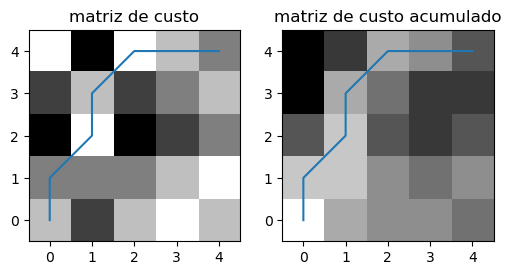

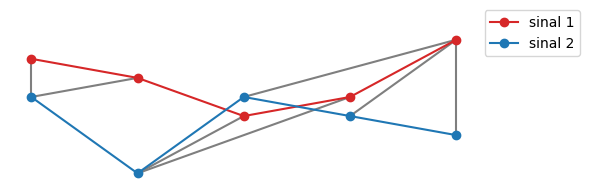

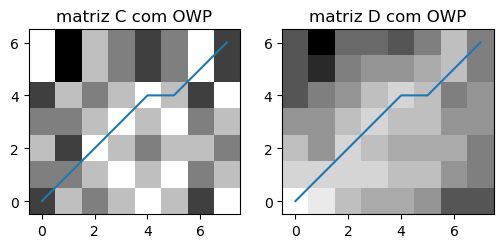

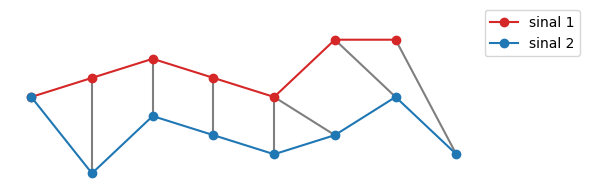

In [9]:
OWP_1 = Optimal_Warping_Path(matriz_custo_cumulativo_1)

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("matriz de custo")
plt.imshow(matriz_custo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*OWP_1)
plt.plot(y_caminho_1, x_caminho_1)
plt.subplot(122)
plt.title("matriz de custo acumulado")
plt.imshow(matriz_custo_cumulativo_1, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*OWP_1)
plt.plot(y_caminho_1, x_caminho_1)

plt.figure(figsize=(6, 2))
plt.plot()
for x_i, y_j in OWP_1:
    plt.plot([x_i, y_j], [sinal_1[x_i] + 1.5, sinal_2[y_j] - 1.5], c="C7")
plt.plot(np.arange(sinal_1.shape[0]), sinal_1 + 1.5, "-o", c="C3", label="sinal 1")
plt.plot(np.arange(sinal_2.shape[0]), sinal_2 - 1.5, "-o", c="C0", label="sinal 2")
plt.legend(loc="center left", bbox_to_anchor=(1,1))
plt.axis("off")

plt.tight_layout()
plt.show();

OWP_2 = Optimal_Warping_Path(matriz_custo_cumulativo_2)

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("matriz C com OWP")
plt.imshow(matriz_custo_2, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_2, y_caminho_2 = zip(*OWP_2)
plt.plot(y_caminho_2, x_caminho_2)
plt.subplot(122)
plt.title("matriz D com OWP")
plt.imshow(matriz_custo_cumulativo_2, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_caminho_1, y_caminho_1 = zip(*OWP_2)
plt.plot(y_caminho_2, x_caminho_2)

plt.figure(figsize=(6, 2))
plt.plot()
for x_i, y_j in OWP_2:
    plt.plot([x_i, y_j], [sinal_3[x_i] + 1.5, sinal_4[y_j] - 1.5], c="C7")
plt.plot(np.arange(sinal_3.shape[0]), sinal_3 + 1.5, "-o", c="C3", label="sinal 1")
plt.plot(np.arange(sinal_4.shape[0]), sinal_4 - 1.5, "-o", c="C0", label="sinal 2")
plt.legend(loc="center left", bbox_to_anchor=(1,1))
plt.axis("off")

plt.tight_layout()
plt.show();

## Codigo da DTW:

A junção de todas as 3 funções acima, recebe 2 sinais e retorna a matriz de custo, matriz de custo acumulado e o Optimal Warping path.

In [10]:
def DTW(sinal_1, sinal_2):
    """ Calcula o alinhamento dinâmico temporal (Dynamic Time Warping - DTW) entre dois sinais temporais.
    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal temporal.
    - sinal_2 (array-like): Segundo sinal temporal.
    Retorna:
    - C (array): Matriz de custo entre as amostras dos dois sinais.
    - D (array): Matriz de custo cumulativo para o alinhamento dinâmico.
    - P (array): Caminho de deformação ótimo como uma matriz de pontos. """

    # Transformando o sinal em um array, caso seja dado uma lista
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])

    # Calcula a matriz de custo cumulativo
    # Obtém as dimensões da matriz de custo original
    N = C.shape[0]
    M = C.shape[1]

    # Inicializa a matriz de custo cumulativo com zeros
    D = np.zeros((N + 1, M + 1))

    # Define infinito nas bordas superiores e laterais da matriz
    for i in range(1, N + 1):
        D[i, 0] = np.inf
    for i in range(1, M + 1):
        D[0, i] = np.inf

    # Preenche iterativamente a matriz de custo cumulativo
    for i in range(N):
        for j in range(M):
            # Lista os custos acumulados das posições vizinhas
            custo_anterior = [
                D[i, j],         # custo vindo da diagonal (amostras iguais)
                D[i, j + 1],      # custo vindo da esquerda (adicionar uma amostra)
                D[i + 1, j]       # custo vindo de cima (remover uma amostra)
            ]
            # Identifica a posição do custo mínimo
            i_custo_anterior = np.argmin(custo_anterior)

            # Calcula o custo cumulativo mínimo para a posição atual
            D[i + 1, j + 1] = C[i, j] + custo_anterior[i_custo_anterior]

    # Remove a linha e coluna adicionadas para inicialização
    D = D[1:, 1:]

    # Calcula o caminho de deformação ótimo
    N = D.shape[0]
    M = D.shape[1]

    i = N - 1       # Inicializa a posição vertical no ponto mais inferior
    j = M - 1       # Inicializa a posição horizontal no ponto mais à direita
    P = [(i, j)]    # Lista que armazenará os pontos do caminho ótimo

    # Enquanto não atingirmos a origem (0, 0)
    while i > 0 or j > 0:
        if i == 0:
            cell = (0, j - 1)  # Se atingir a borda superior, apenas mova para a esquerda
        elif j == 0:
            cell = (i - 1, 0)  # Se atingir a borda esquerda, apenas mova para cima
        else:
            # Encontrar a posição vizinha com o menor custo
            val = min(D[i - 1, j - 1], D[i - 1, j], D[i, j - 1])
            if val == D[i - 1, j - 1]:
                cell = (i - 1, j - 1)  # Movimento diagonal (amostras iguais)
            elif val == D[i - 1, j]:
                cell = (i - 1, j)      # Movimento para cima (remover uma amostra)
            else:
                cell = (i, j - 1)      # Movimento para a esquerda (adicionar uma amostra)

        P.append(cell)  # Adiciona a posição ao caminho ótimo
        (i, j) = cell   # Atualiza a posição para a próxima iteração

    P.reverse()       # Inverte a ordem do caminho para começar do ponto inicial
    P = np.array(P)   # Converte a lista de pontos em uma matriz numpy

    return C, D, P


## Variação da DTW
### Condição de Tamanho de Passo

Na DTW clássico, a condição de tamanho de passo é expressa pelo conjunto $Σ = {(1, 0), (0, 1), (1, 1)}$. Introduzindo uma espécie de condição de continuidade local, essa condição assegura que um caminho de deformação(**warping path**) alinhe cada elemento da sequência $X = (x1, x2, ..., xN)$ a um elemento de $Y = (y1, y2, ..., yM)$ e vice-versa.

Uma desvantagem dessa condição é que um único elemento de uma sequência pode ser atribuído a muitos elementos consecutivos da outra sequência, o que leva a seções verticais e horizontais no caminho de deformação(**warping path**). Intuitivamente, em tais casos, o caminho de deformação fica preso em alguma posição em uma das sequências, enquanto avança na outra sequência. Em termos de tempo físico, essa situação corresponde a uma deformação temporal significativa no alinhamento das duas séries temporais.

Para evitar tais degenerações, é possível modificar a condição de tamanho de passo, restringindo a inclinação dos caminhos de deformação admissíveis, o que pode ser feito substituindo o conjunto $Σ$.

Por exemplo, em vez de usar o conjunto original $Σ = {(1, 0), (0, 1), (1, 1)}$, pode-se utilizar o conjunto $Σ = {(2, 1), (1, 2), (1, 1)}$. Isso resulta em caminhos de deformação com uma inclinação local dentro dos limites de $1/2$ e $2$.  
A matriz de custo acumulado resultante $D$ pode então ser calculada pela recursão:
$$ D(n, m) = C(n, m) + \min
\begin{cases}
D(n-1, m-1) \\
D(n-2, m-1) \\
D(n-1, m-2)
\end{cases}$$
para $n \in [1 : N]$ e $m \in [1 : N]$ com $(n, m) \neq (1, 1)$. Para a inicialização, utiliza-se novamente o truque de estender $D$, desta vez com duas linhas e colunas adicionais (indexadas por $-1$ e $0$). Define-se $D(1, 1) := C(1, 1)$, $D(n, -1) := D(n, 0) := \infty$  para $n \in [-1 : N]$ , e $D(-1, m) := D(0, m) := \infty$ para $m \in [-1 : M]$.  
Observa-se que, em relação à condição de tamanho de passo modificada, existe um caminho de deformação de custo total finito entre duas sequências X e Y se e somente se os comprimentos $N$ e $M$ diferirem por menos de um fator de dois. Além disso, nem todos os elementos de $X$ precisam ser atribuídos a algum elemento de $Y$ e vice-versa.


## Implementação

In [11]:
def DTW_21(sinal_1, sinal_2):
    """ Calcula o alinhamento dinâmico temporal (Dynamic Time Warping - DTW) entre dois sinais temporais
    com condição de passo alterada.
    Parâmetros:
    - sinal_1 (array-like): Primeiro sinal temporal.
    - sinal_2 (array-like): Segundo sinal temporal.
    Retorna:
    - C (array): Matriz de custo entre as amostras dos dois sinais.
    - D (array): Matriz de custo cumulativo para o alinhamento dinâmico.
    - P (array): Caminho de deformação ótimo como uma matriz de pontos."""

    # Transformando o sinal em um array, caso seja dado uma lista
    sinal_1, sinal_2 = np.atleast_2d(sinal_1, sinal_2)

    # Criando a matriz de custo
    N = sinal_1.shape[1]
    M = sinal_2.shape[1]
    C = np.zeros((N, M))

    # Calculando a Distância Euclidiana entre as amostras
    for i in range(N):
        for j in range(M):
            C[i, j] = np.linalg.norm(sinal_1[:, i] - sinal_2[:, j])

    # Calcula a matriz de custo cumulativo
    N = C.shape[0]
    M = C.shape[1]

    D = np.zeros((N + 2, M + 2))
    D[:, 0:2] = np.inf
    D[0:2, :] = np.inf
    D[2, 2] = C[0, 0]

    for i in range(N):
        for j in range(M):
            if i == 0 and j == 0:
                continue
            # Calcula o custo cumulativo mínimo usando a condição de tamanho de passo modificada
            custo_anterior = [
                D[i - 1 + 2, j - 1 + 2],
                D[i - 2 + 2, j - 1 + 2],
                D[i - 1 + 2, j - 2 + 2]
            ]
            i_custo_anterior = np.argmin(custo_anterior)
            D[i + 2, j + 2] = C[i, j] + custo_anterior[i_custo_anterior]
    D = D[2:, 2:]

    # Calcula o caminho de deformação ótimo
    N = D.shape[0]
    M = D.shape[1]
    i = N - 1
    j = M - 1
    P = [(i, j)]

    while i > 0 or j > 0:
        if i == 0:
            cell = (0, j - 1)
        elif j == 0:
            cell = (i - 1, 0)
        else:
            # Encontrar a posição vizinha com o menor custo
            val = min(D[i - 1, j - 1], D[i - 2, j - 1], D[i - 1, j - 2])
            if val == D[i - 1, j - 1]:
                cell = (i - 1, j - 1)
            elif val == D[i - 2, j - 1]:
                cell = (i - 2, j - 1)
            else:
                cell = (i - 1, j - 2)
        P.append(cell)
        (i, j) = cell
    P.reverse()
    P = np.array(P)

    return C, D, P


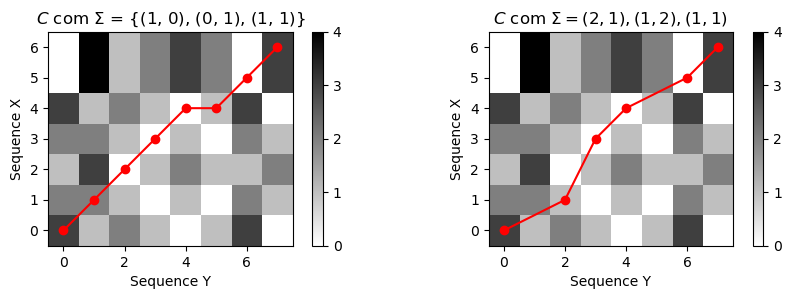

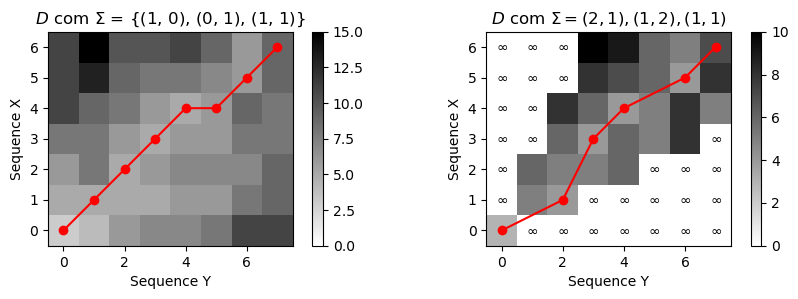

In [12]:
C, D, P = DTW(sinal_3,sinal_4)
C_1, D_1, P_1 = DTW_21(sinal_3, sinal_4)

plt.figure(figsize=(9, 3))
ax = plt.subplot(1, 2, 1)
libfmp.c3.plot_matrix_with_points(C, P, linestyle='-', 
    ax=[ax], aspect='equal', clim=[0, np.max(C)],
    title='$C$ com Σ = {(1, 0), (0, 1), (1, 1)}', xlabel='Sequence Y', ylabel='Sequence X');
ax = plt.subplot(1, 2, 2)
libfmp.c3.plot_matrix_with_points(C_1, P_1, linestyle='-', 
    ax=[ax], aspect='equal', clim=[0, np.max(C)],
    title='$C$ com $Σ = {(2, 1), (1, 2), (1, 1)}$', xlabel='Sequence Y', ylabel='Sequence X');
plt.tight_layout()


plt.figure(figsize=(9, 3))
ax = plt.subplot(1, 2, 1)
D_max = np.nanmax(D[D != np.inf])
libfmp.c3.plot_matrix_with_points(D, P, linestyle='-', 
    ax=[ax], aspect='equal', clim=[0, D_max],
    title='$D$ com Σ = {(1, 0), (0, 1), (1, 1)}', xlabel='Sequence Y', ylabel='Sequence X');
for x, y in zip(*np.where(np.isinf(D))):
    plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')

ax = plt.subplot(1, 2, 2)
D_max = np.nanmax(D_1[D_1 != np.inf])
libfmp.c3.plot_matrix_with_points(D_1, P_1, linestyle='-', 
    ax=[ax], aspect='equal', clim=[0, D_max],
    title='$D$ com $Σ = {(2, 1), (1, 2), (1, 1)}$', xlabel='Sequence Y', ylabel='Sequence X');
for x, y in zip(*np.where(np.isinf(D_1))):
    plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()